# Coverage and Segmentation Labelling (Whole Images)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torchvision.models import resnet18, ResNet18_Weights
import torch.optim as optim

from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import torchvision
from torchvision import datasets, models, transforms


import matplotlib.pyplot as plt
import matplotlib as mpl
#mpl.rcParams.update(mpl.rcParamsDefault) # this is to clear figure settings
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from pylab import *
from matplotlib import  style


import time
import os, glob
import copy
import random


import pandas as pd
from torchvision.io import read_image

from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor


from torch.utils.data import DataLoader, TensorDataset

import json
import pickle


import pretrained_microscopy_models as pmm
import torch.utils.model_zoo as model_zoo
import warnings



from PIL import Image

from utilities import lightness, autocrop



from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score  
from sklearn.metrics import mean_squared_error as mse

from timeit import default_timer as timer



from codes.utils_coverage import CustomImageDataset, grouped_train_test_split
from codes.utils_coverage import model_inference, coverage_models_inference, lightness, autocrop



torch.backends.cudnn.deterministic = True
random.seed(1)
torch.manual_seed(1)
torch.cuda.manual_seed(1)
np.random.seed(1)
batch_size = 100

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:1" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True

In [2]:
print(torch.cuda.mem_get_info(device=None))

(25055854592, 25438126080)


In [2]:

data_dir = 'Data/'

labels = pd.read_csv(os.path.join(data_dir, 'labels-full-wfr.csv'))
label_map = {labels.loc[i, 'filename']: labels.loc[i, 'L_star'] for i in range(len(labels))}

orig_images = list(label_map.keys())
k = 0
for img in orig_images:
    if not os.path.isfile(os.path.join(data_dir, 'FullDataset', img)):
        raise ValueError('Path does not lead to a file')
    k += 1
print(f'Verified {k} file paths')

Verified 221 file paths


In [5]:
image = orig_images[10]

print(image)
print(label_map[image])

MCV2-200821B-TM_200824/Centre_.0_00015_1.spm.tif
105


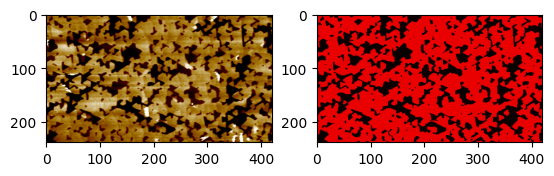

In [6]:


i = 53
f = orig_images[i]
filename = os.path.join(data_dir, 'FullDataset', f)
L_star = label_map[f]

afm = autocrop(Image.open(filename))
mask = Image.fromarray(0.5 + 0.5*(lightness(afm) > L_star).astype(float))

fig, ax = plt.subplots(1, 2)
ax[0].imshow(np.array(afm))
ax[1].imshow(np.array(mask), vmin=0.5, vmax=2.0, cmap='hot')

In [90]:
def make_patch(filename, label_map):
    img_path = os.path.join(data_dir, 'FullDataset', filename)
    L_star = label_map[filename]

    image = autocrop(Image.open(img_path))

    afm = autocrop(Image.open(img_path))

    # resize image to match training case
    min_dim = 512

    width, height = afm.size if isinstance(afm, Image.Image) else afm.shape[-2:]
    if width < height:
        new_height = int(min_dim / width * height)
        afm = afm.resize([min_dim, new_height])
    else:
        new_width = int(min_dim / height * width)
        afm = afm.resize([new_width, min_dim])  

 
    rec = Image.fromarray((lightness(afm) > L_star).astype(float))
    cov = np.sum(np.array(rec)==1)/np.prod(rec.size)

#    img = Image.fromarray(lightness(image))

    img = Image.fromarray(lightness(afm))
    
    if img.mode != 'RGB':
        img = img.convert('RGB')
    

    if rec.mode != 'RGB':
        rec = rec.convert('RGB')

    # print(f'recalculated coverage = {cov:.3f}')
    return img, rec, cov

i = 200
filename = orig_images[i]
x, m, y = make_patch(filename, label_map)

0.007059534001956947
<class 'PIL.Image.Image'>


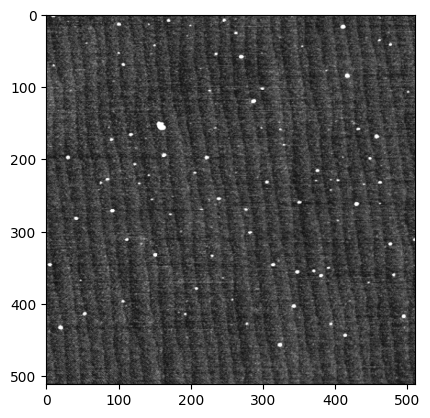

In [91]:
i = 210
filename = orig_images[i]
x, m, y = make_patch(filename, label_map)

print(y)
print(type(x))
fig, ax = plt.subplots()
ax.imshow(np.array(x))

In [92]:
from tqdm import tqdm
from glob import glob
Y = []
whole_image_dir = 'Data/WSe2_2023-11-30_coverage_whole'
if not os.path.isdir(whole_image_dir):
    os.mkdir(whole_image_dir)


pbar = tqdm(enumerate(orig_images), total=len(orig_images))

for i, filename in pbar:
    filename = orig_images[i]
    sample, image = filename.split('/')

#    pbar.set_postfix_str(f'{j:02d} of {n_patch:02d}')
   
    x, m, y = make_patch(filename, label_map)
    Y.append(y)
    # save the patch
    image_name = f"sample_{sample}_image_{image}_label_{y:.5f}.png"
    x.save(os.path.join(whole_image_dir, image_name))

100%|█████████████████████████████████████████| 221/221 [01:11<00:00,  3.11it/s]


In [10]:
# segmentations

data_dir = 'Data/'

labels = pd.read_csv(os.path.join(data_dir, 'labels-full-wfr.csv'))
label_map = {labels.loc[i, 'filename']: labels.loc[i, 'L_star'] for i in range(len(labels))}

orig_images = list(label_map.keys())


full_dir = 'Data/segmentation_data_full'
if not os.path.isdir(full_dir):
    os.mkdir(full_dir)

#n_patch = 1
pbar = tqdm(enumerate(orig_images), total=len(orig_images))

for i, filename in pbar:
    f = orig_images[i]
    sample, image = f.split('/')
    
    filename = os.path.join(data_dir, 'FullDataset', f)
    L_star = label_map[f]

    afm = autocrop(Image.open(filename))

    # resize image to match training case
    min_dim = 512

    width, height = afm.size if isinstance(afm, Image.Image) else afm.shape[-2:]
    if width < height:
        new_height = int(min_dim / width * height)
        afm = afm.resize([min_dim, new_height])
    else:
        new_width = int(min_dim / height * width)
        afm = afm.resize([new_width, min_dim])
        
    mask = Image.fromarray((lightness(afm) > L_star).astype(float))
    
    img = Image.fromarray(lightness(afm))
    
    if img.mode != 'RGB':
        img = img.convert('RGB')

    if mask.mode != 'RGB':
        mask = mask.convert('RGB')

    full_name = f"sample_{sample}_image_{image}_full_.png"
    img.save(os.path.join(full_dir, full_name))
    # also save the binary mask
    mask_name = full_name.replace('_full_', '_mask_')
    mask.save(os.path.join(full_dir, mask_name))